thanks to https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px  
thanks to https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-infer  
train_study: https://www.kaggle.com/h053473666/siim-covid19-efnb7-train-study  
train_image: https://www.kaggle.com/h053473666/siim-cov19-yolov5-train  
train_2class: https://www.kaggle.com/h053473666/siim-covid19-efnb7-train-fold0-5-2class  
  
version1:Original hyperparameters (yolov5)  
version4:New hyperparameters (yolov5)


In [1]:
# -------------package---------------
# efficientnet-keras-source-code
# kerasapplications
# pydicom-conda-helper : pydicom 특정 파일들 unzip

# --------------model----------------
# yolov5-official-v31-dataset : yolo package
# efnb7 train study_level
# efnb7 train 2 classes

In [2]:
!conda install '/kaggle/input/pydicom-conda-helper/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/conda-4.10.1-py37h89c1867_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/openssl-1.1.1k-h7f98852_0.tar.bz2' -c conda-forge -y


######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | / - \ | / - \ | / - \ | / - \ | / done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

#####################

In [3]:
import os
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [4]:
df = pd.read_csv("../input/siim-covid19-detection/sample_submission.csv")
df

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1


현재 test set 은 public test set. length = 2477    
여기서는 public test set 으로 테스트할 때는 작동되는지만 확인하기 위해 일부만 추출해서 시간을 줄인다.   
실제 제출할 때는 private test set 이 주어지므로 (length /= 2477) 그것을 불러와서 예측하게 된다.

In [5]:
# fast_df = df.copy()
# fast_sub = False
if df.shape[0] == 2477:
    fast_sub = True
    fast_df = pd.DataFrame(([['00086460a852_study', 'negative 1 0 0 1 1'], 
                             ['000c9c05fd14_study', 'negative 1 0 0 1 1'], 
                             ['65761e66de9f_image', 'none 1 0 0 1 1'], 
                             ['51759b5579bc_image', 'none 1 0 0 1 1']]), 
                           columns=['id', 'PredictionString'])
else:
    fast_sub = False

# .dcm to .png

In [6]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [7]:
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

In [8]:
split = 'test'
save_dir = f'../tmp/{split}/'

os.makedirs(save_dir, exist_ok=True)

save_dir = f'../tmp/{split}/study/'
os.makedirs(save_dir, exist_ok=True)

len(glob('../tmp/*'))

1

In [9]:
if fast_sub:
    xray = read_xray('../input/siim-covid19-detection/train/00086460a852/9e8302230c91/65761e66de9f.dcm')
    im = resize(xray, size=600)  
    study = '00086460a852' + '_study.png'
    im.save(os.path.join(save_dir, study))
    xray = read_xray('../input/siim-covid19-detection/train/000c9c05fd14/e555410bd2cd/51759b5579bc.dcm')
    im = resize(xray, size=600)  
    study = '000c9c05fd14' + '_study.png'
    im.save(os.path.join(save_dir, study))
else:
    for dirname, _, filenames in tqdm(os.walk(f'../input/siim-covid19-detection/{split}')):
        for file in filenames:
            # set keep_ratio=True to have original aspect ratio
            xray = read_xray(os.path.join(dirname, file))
            im = resize(xray, size=600)  
            study = dirname.split('/')[-2] + '_study.png'
            im.save(os.path.join(save_dir, study))

In [10]:
image_id = []
dim0 = []
dim1 = []
splits = []
save_dir = f'../working/tmp/{split}/image/'
os.makedirs(save_dir, exist_ok=True)
if fast_sub:
    xray = read_xray('../input/siim-covid19-detection/train/00086460a852/9e8302230c91/65761e66de9f.dcm')
    im = resize(xray, size=512)  
    im.save(os.path.join(save_dir,'65761e66de9f_image.png'))
    image_id.append('65761e66de9f.dcm'.replace('.dcm', ''))
    dim0.append(xray.shape[0])
    dim1.append(xray.shape[1])
    splits.append(split)
    xray = read_xray('../input/siim-covid19-detection/train/000c9c05fd14/e555410bd2cd/51759b5579bc.dcm')
    im = resize(xray, size=512)  
    im.save(os.path.join(save_dir, '51759b5579bc_image.png'))
    image_id.append('51759b5579bc.dcm'.replace('.dcm', ''))
    dim0.append(xray.shape[0])
    dim1.append(xray.shape[1])
    splits.append(split)
else:
    for dirname, _, filenames in tqdm(os.walk(f'/../input/siim-covid19-detection/{split}')):
        for file in filenames:
            # set keep_ratio=True to have original aspect ratio
            xray = read_xray(os.path.join(dirname, file))
            im = resize(xray, size=512)  
            im.save(os.path.join(save_dir, file.replace('.dcm', '_image.png')))
            image_id.append(file.replace('.dcm', ''))
            dim0.append(xray.shape[0])
            dim1.append(xray.shape[1])
            splits.append(split)
meta = pd.DataFrame.from_dict({'image_id': image_id, 'dim0': dim0, 'dim1': dim1, 'split': splits})

# study predict

In [11]:
import numpy as np 
import pandas as pd

if fast_sub:
    df = fast_df.copy()
else:
    df = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')

id_laststr_list  = []
for i in range(df.shape[0]):
    id_laststr_list.append(df.loc[i,'id'][-1])
df['id_last_str'] = id_laststr_list

study_len = df[df['id_last_str'] == 'y'].shape[0]
print(study_len)
df

2


,id,PredictionString,id_last_str
0,00086460a852_study,negative 1 0 0 1 1,y
1,000c9c05fd14_study,negative 1 0 0 1 1,y
2,65761e66de9f_image,none 1 0 0 1 1,e
3,51759b5579bc_image,none 1 0 0 1 1,e


In [12]:
study_predict = False
if study_predict:
    !pip install /kaggle/input/kerasapplications -q
    !pip install /kaggle/input/efficientnet-keras-source-code/ -q --no-deps

    import os
    

    import efficientnet.tfkeras as efn
    import numpy as np
    import pandas as pd
    import tensorflow as tf

    def auto_select_accelerator():
        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("Running on TPU:", tpu.master())
        except ValueError:
            strategy = tf.distribute.get_strategy()
        print(f"Running on {strategy.num_replicas_in_sync} replicas")

        return strategy


    def build_decoder(with_labels=True, target_size=(300, 300), ext='jpg'):
        def decode(path):
            file_bytes = tf.io.read_file(path)
            if ext == 'png':
                img = tf.image.decode_png(file_bytes, channels=3)
            elif ext in ['jpg', 'jpeg']:
                img = tf.image.decode_jpeg(file_bytes, channels=3)
            else:
                raise ValueError("Image extension not supported")

            img = tf.cast(img, tf.float32) / 255.0
            img = tf.image.resize(img, target_size)

            return img

        def decode_with_labels(path, label):
            return decode(path), label

        return decode_with_labels if with_labels else decode


    def build_augmenter(with_labels=True):
        def augment(img):
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_flip_up_down(img)
            return img

        def augment_with_labels(img, label):
            return augment(img), label

        return augment_with_labels if with_labels else augment


    def build_dataset(paths, labels=None, bsize=32, cache=True,
                      decode_fn=None, augment_fn=None,
                      augment=True, repeat=True, shuffle=1024, 
                      cache_dir=""):
        if cache_dir != "" and cache is True:
            os.makedirs(cache_dir, exist_ok=True)

        if decode_fn is None:
            decode_fn = build_decoder(labels is not None)

        if augment_fn is None:
            augment_fn = build_augmenter(labels is not None)

        AUTO = tf.data.experimental.AUTOTUNE
        slices = paths if labels is None else (paths, labels)

        dset = tf.data.Dataset.from_tensor_slices(slices)
        dset = dset.map(decode_fn, num_parallel_calls=AUTO)
        dset = dset.cache(cache_dir) if cache else dset
        dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
        dset = dset.repeat() if repeat else dset
        dset = dset.shuffle(shuffle) if shuffle else dset
        dset = dset.batch(bsize).prefetch(AUTO)

        return dset

    #COMPETITION_NAME = "siim-cov19-test-img512-study-600"
    strategy = auto_select_accelerator()
    BATCH_SIZE = strategy.num_replicas_in_sync * 16

    IMSIZE = (224, 240, 260, 300, 380, 456, 528, 600, 512)

    #load_dir = f"/kaggle/input/{COMPETITION_NAME}/"
    if fast_sub:
        sub_df = fast_df.copy()
    else:
        sub_df = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')
    sub_df = sub_df[:study_len]
    test_paths = f'../tmp/{split}/study/' + sub_df['id'] +'.png'

    sub_df['negative'] = 0
    sub_df['typical'] = 0
    sub_df['indeterminate'] = 0
    sub_df['atypical'] = 0


    label_cols = sub_df.columns[2:]

    test_decoder = build_decoder(with_labels=False, target_size=(IMSIZE[7], IMSIZE[7]), ext='png')
    dtest = build_dataset(
        test_paths, bsize=BATCH_SIZE, repeat=False, 
        shuffle=False, augment=False, cache=False,
        decode_fn=test_decoder
    )

    with strategy.scope():

        models = []

        models0 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-study/model0.h5'
        )
        models1 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-study/model1.h5'
        )
        models2 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-study/model2.h5'
        )
        models3 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-study/model3.h5'
        )
        models4 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-study/model4.h5'
        )

        models.append(models0)
        models.append(models1)
        models.append(models2)
        models.append(models3)
        models.append(models4)




    sub_df[label_cols] = sum([model.predict(dtest, verbose=1) for model in models]) / len(models)

In [13]:
if study_predict:
    sub_df.columns = ['id', 'PredictionString1', 'negative', 'typical', 'indeterminate', 'atypical']
    df = pd.merge(df, sub_df, on = 'id', how = 'left')

# study string

In [14]:
study_string = False
if study_string:
    for i in range(study_len):
        negative = df.loc[i,'negative']
        typical = df.loc[i,'typical']
        indeterminate = df.loc[i,'indeterminate']
        atypical = df.loc[i,'atypical']
        df.loc[i, 'PredictionString'] = f'negative {negative} 0 0 1 1 typical {typical} 0 0 1 1 indeterminate {indeterminate} 0 0 1 1 atypical {atypical} 0 0 1 1'

In [15]:
if study_string:
    df_study = df[['id', 'PredictionString']]

# df.to_csv('submission.csv',index=False)
# df

# 2 class

In [16]:
two_classes = False
if two_classes:
    if fast_sub:
        sub_df = fast_df.copy()
    else:
        sub_df = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')
    sub_df = sub_df[study_len:]
    test_paths = f'../tmp/{split}/image/' + sub_df['id'] +'.png'
    sub_df['none'] = 0

    label_cols = sub_df.columns[2]

    test_decoder = build_decoder(with_labels=False, target_size=(IMSIZE[8], IMSIZE[8]), ext='png')
    dtest = build_dataset(
        test_paths, bsize=BATCH_SIZE, repeat=False, 
        shuffle=False, augment=False, cache=False,
        decode_fn=test_decoder
    )

    with strategy.scope():

        models = []

        models0 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-fold0-5-2class/model0.h5'
        )
        models1 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-fold0-5-2class/model1.h5'
        )
        models2 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-fold0-5-2class/model2.h5'
        )
        models3 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-fold0-5-2class/model3.h5'
        )
        models4 = tf.keras.models.load_model(
            '../input/siim-covid19-efnb7-train-fold0-5-2class/model4.h5'
        )

        models.append(models0)
        models.append(models1)
        models.append(models2)
        models.append(models3)
        models.append(models4)




    sub_df[label_cols] = sum([model.predict(dtest, verbose=1) for model in models]) / len(models)
    df_2class = sub_df.reset_index(drop=True)

In [17]:
if two_classes:
    del models
    del models0, models1, models2, models3, models4

In [18]:
if two_classes:
    from numba import cuda
    import torch
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

----
# yolov5 predict

In [19]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import torch

In [20]:
#display(meta, fast_df, df)

In [21]:
meta = meta[meta['split'] == 'test']

if fast_sub:
    test_df = fast_df.copy()
else:
    test_df = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')
    
test_df = df[study_len:].reset_index(drop=True) 
meta['image_id'] = meta['image_id'] + '_image'
meta.columns = ['id', 'dim0', 'dim1', 'split']
test_df = pd.merge(test_df, meta, on = 'id', how = 'left')
test_df
# only image_level

,id,PredictionString,id_last_str,dim0,dim1,split
0,65761e66de9f_image,none 1 0 0 1 1,e,2330,2783,test
1,51759b5579bc_image,none 1 0 0 1 1,e,3093,2850,test


In [22]:
import shutil, os

original_path = os.getcwd()
original_path

dim = 512
test_dir = f'/kaggle/working/tmp/{split}/image'
#weights_dir = '/kaggle/input/siim-cov19-yolov5-train/yolov5/runs/train/exp/weights/last.pt'
weights_dir = '/kaggle/input/yolov5-train-image/kaggle/working/yolov5/runs/train/exp/weights/best.pt'
if os.path.isdir('/kaggle/working/yolov5'):
    shutil.rmtree('/kaggle/working/yolov5')
shutil.copytree(src = '/kaggle/input/yolov5-official-v31-dataset/yolov5',
                dst = '/kaggle/working/yolov5')

os.chdir('/kaggle/working/yolov5') # install dependencies

import torch
#from IPython.display import Image, clear_output  # to display images

#clear_output()
#print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# 기존에 존재하는 txt 파일에 label 이 append 되도록 코드가 구성되어 있으므로, 실행 전에 shutil.rmtree 실행해주자

!python detect.py --weights $weights_dir\
--img 512\
--conf 0.01\
--iou 0.5\
--source $test_dir\
--save-txt --save-conf --exist-ok

# --conf : code default 0.25 / Notebook default 0.001

# --conf : 코드 확인해보니, confidence threshold 값이다. 
# train_code 에서 detect and draw plot 에서는 이게 0.1로 설정되어 있었다.
# 근데 0.1 로 바꿔도 왜 똑같지?

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.01, device='', exist_ok=True, img_size=512, iou_thres=0.5, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/kaggle/working/tmp/test/image', update=False, view_img=False, weights=['/kaggle/input/yolov5-train-image/kaggle/working/yolov5/runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/2 /kaggle/working/tmp/test/image/51759b5579bc_image.png: 512x512 3 0. opacitys, Done. (0.040s)
image 2/2 /kaggle/working/tmp/test/image/65761e66de9f_image.png: 512x512 9 0. opacitys, Done. (0.022s)
Results saved to runs/detect/exp
2 labels saved to runs/detect/exp/labels
Done. (0.264s)


In [23]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y2]
    """
    bboxes = bboxes.copy().astype(float) #otherwise all value will be 0 as voc_pascal dtype is np.int

    bboxes[..., [0,2]] = bboxes[..., [0,2]] * image_width
    bboxes[..., [1,3]] = bboxes[..., [1,3]] * image_height
    
    bboxes[..., [0,1]] = bboxes[..., [0,1]] - bboxes[..., [2,3]]/2
    bboxes[..., [2,3]] = bboxes[..., [0,1]] + bboxes[..., [2,3]]/2
    
    return bboxes

In [24]:
if fast_sub:
    expect = [file for file in glob('/kaggle/working/yolov5/runs/detect/exp/*') \
             if file.split('.')[-1] == 'png']
    expect_label = [file for file in glob('/kaggle/working/yolov5/runs/detect/exp/*') \
             if file.split('.')[-1] != 'png']

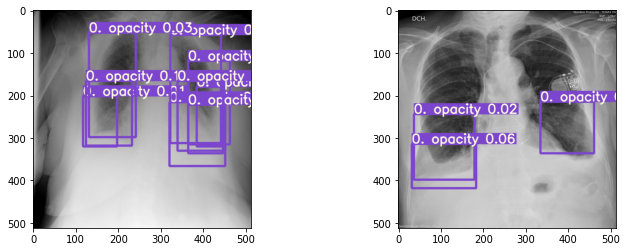

In [25]:
if fast_sub:
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].imshow(plt.imread(expect[0]))
    axes[1].imshow(plt.imread(expect[1]))

In [26]:
if fast_sub:
    expect_labels = glob(expect_label[0] + '/*')
    for label_text in expect_labels:
        print(label_text.split('/')[-1])
        with open(label_text) as f:
            print(f.read())
# conf-threshold 를 바꿔도 이 txt 파일이 바뀌지 않았던 이유는, 코드를 살펴보니 open('a') : append 로 되어있었기 때문
# yolov5 detect.py 코드 구성상, txt file 은 open append 로 되어있어서 실행전에 shutil.rmtree 코드 추가함.

65761e66de9f_image.txt
0 0.806641 0.423828 0.191406 0.382812 0.0105286
0 0.8125 0.488281 0.125 0.273438 0.0112152
0 0.306641 0.509766 0.15625 0.230469 0.0125809
0 0.75293 0.568359 0.255859 0.292969 0.0136642
0 0.745117 0.361328 0.232422 0.496094 0.0142136
0 0.791016 0.544922 0.160156 0.222656 0.0219269
0 0.363281 0.342773 0.214844 0.478516 0.0307465
0 0.347656 0.472656 0.210938 0.296875 0.150146
0 0.766602 0.484375 0.208984 0.320312 0.158447

51759b5579bc_image.txt
0 0.210938 0.626953 0.277344 0.300781 0.021286
0 0.775391 0.538086 0.246094 0.236328 0.0351257
0 0.209961 0.714844 0.294922 0.203125 0.0643921



In [27]:
test_df

,id,PredictionString,id_last_str,dim0,dim1,split
0,65761e66de9f_image,none 1 0 0 1 1,e,2330,2783,test
1,51759b5579bc_image,none 1 0 0 1 1,e,3093,2850,test


In [28]:
image_ids = []
PredictionStrings = []
for file_path in tqdm(glob('/kaggle/working/yolov5/runs/detect/exp/labels/*.txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.id==image_id, ['dim1','dim0']].values[0] # 512 로 예측한 것을 본래 크기에 맞게 resizing
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1,6)
    data = data[:, [0, 5, 1, 2, 3, 4]] # opacity, confidence, bboxees
    bboxes = list(np.round(
        np.concatenate((data[:, :2], # opacity, confidence
                        np.round(yolo2voc(h, w, data[:,2:]))), axis=1).reshape(-1), 12).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6 != 1 else bboxes[idx] # confidence 제외 str
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))
pred_df = pd.DataFrame({'id':image_ids,
                        'PredictionString':PredictionStrings})

  0%|          | 0/2 [00:00<?, ?it/s]

In [29]:
display(pred_df, test_df)

,id,PredictionString
0,65761e66de9f_image,0 0.010528599843 1979 542 2245 988 0 0.0112151...
1,51759b5579bc_image,0 0.021285999566 206 1474 601 1939 0 0.0351256...


,id,PredictionString,id_last_str,dim0,dim1,split
0,65761e66de9f_image,none 1 0 0 1 1,e,2330,2783,test
1,51759b5579bc_image,none 1 0 0 1 1,e,3093,2850,test


In [30]:
test_df = test_df.drop(['PredictionString'], axis=1)
sub_df = pd.merge(test_df, pred_df, on = 'id', how='left').fillna("none 1 0 0 1 1")
sub_df = sub_df[['id', 'PredictionString']]
sub_df

,id,PredictionString
0,65761e66de9f_image,0 0.010528599843 1979 542 2245 988 0 0.0112151...
1,51759b5579bc_image,0 0.021285999566 206 1474 601 1939 0 0.0351256...


In [31]:
# make a format for submission
for i in range(sub_df.shape[0]):
    if sub_df.loc[i, 'PredictionString'] == "none 1 0 0 1 1":
        continue
    sub_df_split = sub_df.loc[i, 'PredictionString'].split()
    sub_df_list = []
    for j in range(int(len(sub_df_split)/6)):
        sub_df_list.append('opacity')               # 0 to opacity
        sub_df_list.append(sub_df_split[6 * j + 1]) # confidence
        sub_df_list.append(sub_df_split[6 * j + 2]) # x_min
        sub_df_list.append(sub_df_split[6 * j + 3]) # y_min
        sub_df_list.append(sub_df_split[6 * j + 4]) # x_max
        sub_df_list.append(sub_df_split[6 * j + 5]) # y_max
    sub_df.loc[i, 'PredictionString'] = ' '.join(sub_df_list)
sub_df

,id,PredictionString
0,65761e66de9f_image,opacity 0.010528599843 1979 542 2245 988 opaci...
1,51759b5579bc_image,opacity 0.021285999566 206 1474 601 1939 opaci...


In [32]:
# 여기는 2 classfier 개념인데, 한번 봐봐야겠다.
if two_classes:
    sub_df['none'] = df_2class['none']
    for i in range(sub_df.shape[0]):
        if sub_df.loc[i, 'PredictionString'] != 'none 1 0 0 1 1':
            sub_df.loc[i, 'PredictionString'] = sub_df.loc[i, 'PredictionString'] + \
            ' none ' + str(sub_df.loc[i, 'none']) + ' 0 0 1 1'
    sub_df = sub_df[['id','PredictionString']]
    
if study_predict:
    df_study = df_study[:study_len]
    df_study = df_study.append(sub_df).reset_index(drop=True)
    df_study.to_csv('/kaggle/working/submission.csv',index = False)  
    shutil.rmtree('/kaggle/working/yolov5')

In [33]:
df_study = df[:study_len][['id','PredictionString']]

study_str = 'negative 1 0 0 1 1 atypical 1 0 0 1 1 typical 1 0 0 1 1 indeterminate 1 0 0 1 1'
for i in range(study_len):
    df.loc[i, 'PredictionString'] = study_str
# 현재 image_level 만 변경했을 때 어떻게 점수가 바뀌는지 보는 것이므로, df_study 는 기존 연구의 연장으로,
# 일단 0.230 일때의 값과 같게 설정해줘야 한다. 이걸 빼먹었네
    
df_study = df_study.append(sub_df).reset_index(drop=True)
df_study.to_csv("/kaggle/working/submission.csv", index=False)
if os.path.exists('/kaggle/working/yolov5'):
    shutil.rmtree('/kaggle/working/yolov5')
if os.path.exists('/kaggle/working/tmp'):
    shutil.rmtree('/kaggle/working/tmp')

In [34]:
df_study

,id,PredictionString
0,00086460a852_study,negative 1 0 0 1 1
1,000c9c05fd14_study,negative 1 0 0 1 1
2,65761e66de9f_image,opacity 0.010528599843 1979 542 2245 988 opaci...
3,51759b5579bc_image,opacity 0.021285999566 206 1474 601 1939 opaci...


In [35]:
df = pd.read_csv("/kaggle/input/siim-covid19-detection/sample_submission.csv")
study_str = 'negative 1 0 0 1 1 atypical 1 0 0 1 1 typical 1 0 0 1 1 indeterminate 1 0 0 1 1'
for i in range(study_len):
    df.loc[i, 'PredictionString'] = study_str
df.to_csv("/kaggle/working/submission.csv", index=False)